# Astropy Tutorial

Import neccessary packages

In [2]:
import numpy as np
import sep

In [3]:
# additional setup for reading the test image and displaying plots
import matplotlib.pyplot as plt
import astropy

from astropy.io import fits
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

save_path = '/Users/labuser/Desktop/'

In [6]:
# read image into standard 2-d numpy array
#data = fits.open('./data/image.fits') #where I upload image fits on the Jupter Notebook
filename = "/Users/labuser/Desktop/image.fits"     #path of file on my laptp
hdu_list = fits.open(filename)                        #opens the fits file
hdu_list.info()                                    #outputs the information of the file

# location of the image in the lsit and reassign this item to image_data
image_data = hdu_list[0].data


#Note: If WARNINGS arise, do not pay attention. This is just a formatting error in the fits file.

Filename: /Users/labuser/Desktop/image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     337   (256, 256)   int16 (rescales to float32)   


ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


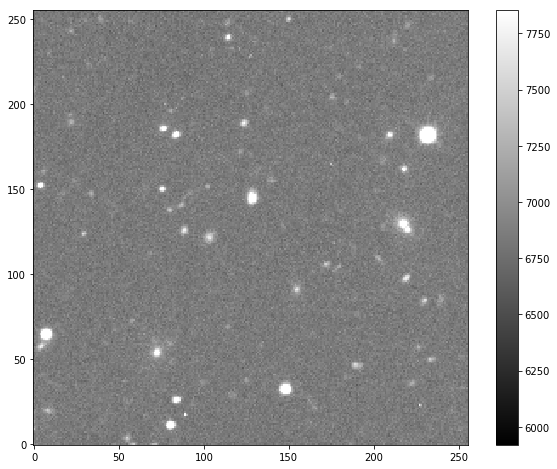

In [9]:
image_data = fits.getdata(filename)
# show the image
m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

#Save the background at a high resolution.
plt.savefig(save_path + 'raw_image.png', dpi = 600)

# Background subtraction

One way to fix the noise from the background image is to subtract the background from the optical/IR data.

In [11]:
#Measure a spatially varying background on the image
bkg = sep.Background(image_data)

#There are various options for controlling the box size used in estimating the background. It is also possible to mask pixels. For example:
bkg = sep.Background(image_data, bw=64, bh=64, fw=3, fh=3)

# get a "global" mean and noise of the image background
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


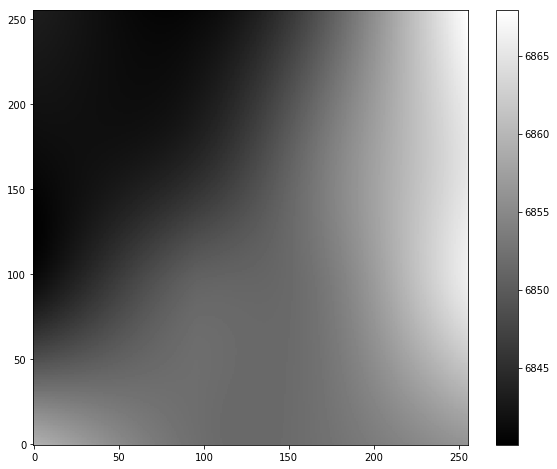

In [12]:
#Evaluate the backgroud as 2-D array and show the background.
bkg_image = bkg.back()
#bkg_image = np.array(bkg) # equivalent to above

#show the backgroun
plt.imshow(bkg_image, interpolation = 'nearest', cmap = 'gray', origin = 'lower')
plt.colorbar();

#Save the background at a high resolution.
plt.savefig(save_path + 'background.png', dpi = 600)

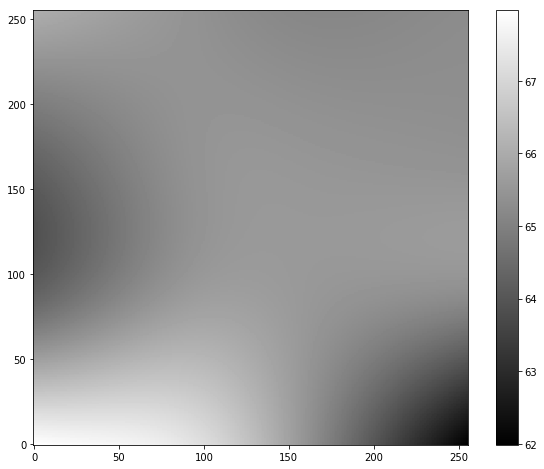

In [13]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

#show the background noise
plt.imshow(bkg_rms, interpolation = 'nearest', cmap = 'gray', origin = 'lower')
plt.colorbar();

#Save the background at a high resolution.
plt.savefig(save_path + 'background_noise.png', dpi = 600)

In [15]:
# subtract the background
data_sub = image_data - bkg

# Oject detection
Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of 1.5σ where σ is the global background RMS.

In [16]:
objects = sep.extract(data_sub, 1.5, err = bkg.globalrms)

#Number of objects detected
len(objects)

68

Just to check where the detected objects are, we’ll over-plot the object coordinates with some basic shape parameters on the image:

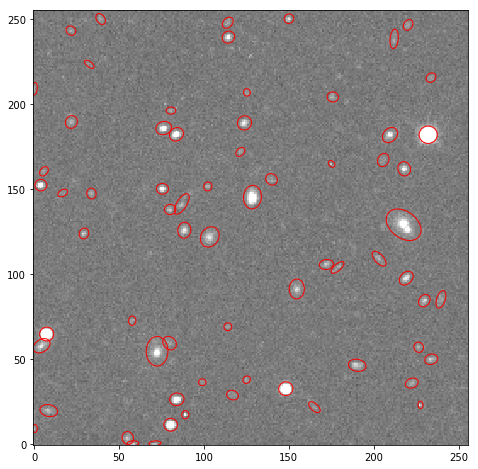

In [17]:
from matplotlib.patches import Ellipse    #Ellipse fitting

#plot bagkround_subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation = 'nearest', cmap = 'gray', vmin = m - s, vmax = m + s, origin = 'lower')

#plot an ellipse for each object
#objects['x'] and objects['y'] will give the centroid coordinates of the objects.
for i in range(len(objects)):
    e = Ellipse(xy = (objects['x'][i], objects['y'][i]), width = 6*objects['a'][i], height = 6*objects['b'][i], angle = objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')   #leaves the center of the ellipse clear
    e.set_edgecolor('red')    #outlines the ellipse with a specified color
    ax.add_artist(e)          #add the ellipse to the image

#Save the background at a high resolution.
plt.savefig(save_path + 'image_object_detection.png', dpi = 600)

There is a list of all the available field.

In [18]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [ ]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err = bkg.globalrms, gain = 1.0)

In [ ]:
#here we loop through each object to obtain its flux with error
for i in range(len(objects)):
    print("object {:d}: flux = {:f} +/- {:f}".format(i + 1, flux[i], fluxerr[i]))